In [1]:
import numpy as np
import cv2
import glob
from scipy.io import loadmat
from scipy.optimize import least_squares
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as pt
%matplotlib notebook

########## function to normalize the pixel coordinates matched using the camera intrinsic matrix ########
def normalize_coordinates(points , K) :
    
    ###### cx , cy are the 1st and 2nd element of 3rd column in K matrix #######
    C = np.array([K[0,2],K[1,2]]).reshape(1,2,1)
    ###### fx and fy are the 1st and 2nd diagonal elements in K matrix ######
    f = np.array([K[0,0],K[1,1]]).reshape(1,2,1)
    ###### calculating the normalized camera coordinates from matched points i.e. pij ######
    normalized_points = (points - C)/f
    
    return normalized_points

def reprojection_error(x,*args) :
    ######## passing number of views and normalized matched 2d points as arguments ######
    n_views = args[0]
    norm_points = args[1]
    
    ######## reshaping the x array into W, theta and transition matrices i.e. the learnable parameters #######
    W = x[:norm_points.shape[0]]
    theta = x[norm_points.shape[0]:norm_points.shape[0]+(3*n_views)].reshape(-1,3)
    translation = x[norm_points.shape[0]+(3*n_views):].reshape(-1,3)
    
    ######### reference frame 3d points #########
    reference_3d_points = np.concatenate([norm_points[:,:,0],np.ones((norm_points.shape[0],1))],axis=1)
    reference_3d_points = reference_3d_points/W.reshape(-1,1)
    
    ########## forming the rotation matrix from theta. Used the approximation mentioned in assignment pdf #######
    R = np.ones((n_views,3,3))
    R[:,0,1] = -theta[:,2]
    R[:,0,2] = theta[:,1]
    R[:,1,0] = theta[:,2]
    R[:,1,2] = -theta[:,0]
    R[:,2,0] = -theta[:,1]
    R[:,2,1] = theta[:,0]
    
    ########### calculating the reprojected 2d points onto various views using the R,T,w ########
    reprojected_2d_points_homo = np.dot(R , reference_3d_points.T) + translation.reshape(n_views,-1,1)
    
    ######### computing the error matrix ##########
    reprojected_2d_points_hetero = reprojected_2d_points_homo[:,:-1,:]/reprojected_2d_points_homo[:,-1,:].reshape(n_views,-1,norm_points.shape[0])
    error = ((reprojected_2d_points_hetero.T - norm_points[:,:,:n_views])**2).ravel()
    
    return error

########## Loading intrinsics matrix and matched points ##############
matched_points = loadmat('matchedPoints.mat')['matchedPoints']
cam_intrinsics = loadmat('IntrinsicsMCV.mat')['IntrinsicMatrix']

norm_points = normalize_coordinates(matched_points , cam_intrinsics)

In [2]:
############### 5 VIEWS ################
n_views = 5
x_initial = np.ones(norm_points.shape[0]+ n_views*3*2)
x_initial[-2*n_views*3:] = 0

######### computing the parameters for 5 views #######
params_5 = least_squares(reprojection_error , x0 = x_initial ,verbose = 2, ftol = 1e-2 , args=[n_views,norm_points])

W_5 = params_5['x'][:norm_points.shape[0]]
theta_5 = params_5['x'][norm_points.shape[0]:norm_points.shape[0]+(n_views*3)].reshape(n_views,3)
translation_5 = params_5['x'][norm_points.shape[0]+(n_views*3):].reshape(n_views,3)

######## computing the point cloud for 5 views ########
point_cloud_5 = np.concatenate([norm_points[:,:,0],np.ones((norm_points.shape[0],1))],axis=1)
point_cloud_5 = point_cloud_5/W_5.reshape(-1,1)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7854e-05                                    2.79e-03    
       1              2         7.0273e-06      1.08e-05       2.84e+01       2.82e-03    
       2              3         2.1324e-07      6.81e-06       2.84e+01       1.03e-04    
       3              4         1.8669e-08      1.95e-07       5.68e+01       1.66e-05    
       4              6         3.0025e-09      1.57e-08       2.84e+01       5.12e-06    
       5              8         2.4726e-09      5.30e-10       1.42e+01       2.96e-06    
       6              9         4.3772e-10      2.03e-09       3.55e+00       7.63e-07    
       7             10         1.5304e-10      2.85e-10       7.10e+00       2.43e-07    
       8             11         1.0948e-10      4.36e-11       7.10e+00       1.71e-07    
       9             12         7.9853e-11      2.96e-11       7.10e+00       1.31e-07    

In [3]:
layout = pt.Layout(title = 'Point Cloud for 5 views')
fig = pt.Figure(data=[pt.Scatter3d(x=point_cloud_5[:, 0], y=point_cloud_5[:, 1], z=point_cloud_5[:, 2], mode="markers", marker=dict(size=2.5))],layout = layout)
fig.show()

In [4]:
############### 15 VIEWS ################
n_views = 15
x_initial = np.ones(norm_points.shape[0]+ n_views*3*2)
x_initial[-2*n_views*3:] = 0

######## computing the parameters for 15 views ########
params_15 = least_squares(reprojection_error , x0 = x_initial ,verbose = 2, ftol = 1e-2 , args=[n_views,norm_points])


W_15 = params_15['x'][:norm_points.shape[0]]
theta_15 = params_15['x'][norm_points.shape[0]:norm_points.shape[0]+(n_views*3)].reshape(n_views,3)
translation_15 = params_15['x'][norm_points.shape[0]+(n_views*3):].reshape(n_views,3)

######## computing the point cloud for 15 views #########
point_cloud_15 = np.concatenate([norm_points[:,:,0],np.ones((norm_points.shape[0],1))],axis=1)
point_cloud_15 = point_cloud_15/W_15.reshape(-1,1)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2726e-04                                    1.95e-02    
       1              2         2.9783e-04      1.29e-04       2.84e+01       2.91e-02    
       2              3         3.4063e-05      2.64e-04       2.84e+01       3.29e-03    
       3              4         2.4182e-06      3.16e-05       5.68e+01       5.20e-04    
       4              6         4.4004e-07      1.98e-06       2.84e+01       1.69e-04    
       5              8         2.0284e-07      2.37e-07       1.42e+01       5.20e-05    
       6             10         2.5280e-08      1.78e-07       3.55e+00       1.09e-05    
       7             12         2.8335e-09      2.24e-08       1.78e+00       2.01e-06    
       8             13         5.0607e-10      2.33e-09       3.55e+00       2.49e-07    
       9             14         3.3528e-10      1.71e-10       7.10e+00       2.45e-07    

In [5]:
layout = pt.Layout(title = 'Point Cloud for 15 views')
fig_15 = pt.Figure(data=[pt.Scatter3d(x=point_cloud_15[:, 0], y=point_cloud_15[:, 1], z=point_cloud_15[:, 2], mode="markers", marker=dict(size=2.5))],layout=layout)
fig_15.show()

In [6]:
############### 25 VIEWS ################
n_views = 25
x_initial = np.ones(norm_points.shape[0]+ n_views*3*2)
x_initial[-2*n_views*3:] = 0

######## computing parameters for 25 views ########
params_25 = least_squares(reprojection_error , x0 = x_initial ,verbose = 2, ftol = 1e-2 , args=[n_views,norm_points])

W_25 = params_25['x'][:norm_points.shape[0]]
theta_25 = params_25['x'][norm_points.shape[0]:norm_points.shape[0]+(n_views*3)].reshape(n_views,3)
translation_25 = params_25['x'][norm_points.shape[0]+(n_views*3):].reshape(n_views,3)

######## computing point cloud for 25 views #########
point_cloud_25 = np.concatenate([norm_points[:,:,0],np.ones((norm_points.shape[0],1))],axis=1)
point_cloud_25 = point_cloud_25/W_25.reshape(-1,1)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1260e-03                                    3.58e-02    
       1              2         6.4174e-04      4.84e-04       2.84e+01       1.91e-02    
       2              3         1.3035e-05      6.29e-04       2.84e+01       1.34e-03    
       3              6         1.0562e-06      1.20e-05       3.55e+00       1.97e-04    
       4              7         7.9785e-07      2.58e-07       7.10e+00       1.45e-04    
       5              8         6.7919e-08      7.30e-07       1.78e+00       2.38e-05    
       6              9         4.9318e-09      6.30e-08       3.55e+00       2.58e-06    
       7             10         4.6882e-09      2.44e-10       7.10e+00       2.84e-06    
       8             11         1.0385e-09      3.65e-09       1.78e+00       3.67e-07    
       9             13         7.8235e-10      2.56e-10       8.88e-01       9.11e-08    

In [7]:
layout = pt.Layout(title = 'Point Cloud for 25 views')
fig_25 = pt.Figure(data=[pt.Scatter3d(x=point_cloud_25[:, 0], y=point_cloud_25[:, 1], z=point_cloud_25[:, 2], mode="markers", marker=dict(size=2))],layout=layout)
fig_25.show()

In [8]:
############ PLANE SWEEP METHOD #############

def plane_sweep( theta , T , W , K , images) :
    
    ######### forming the rotation matrices from theta #####
    R = np.ones((theta.shape[0],3,3))
    R[:,0,1] = -theta[:,2]
    R[:,0,2] = theta[:,1]
    R[:,1,0] = theta[:,2]
    R[:,1,2] = -theta[:,0]
    R[:,2,0] = -theta[:,1]
    R[:,2,1] = theta[:,0]
    
    ######## taking 10 depth planes between min and max value of depths #########
    ######## since W is the inverse depth, we use 1/minW and 1/maxW #########
    min_W = np.min(W)
    max_W = np.max(W)
    d = np.linspace(1/max_W , 1/min_W , 10)
    
    ######## Computing the inverse homograhies for each planar region and view ########
    H_inv = np.zeros((R.shape[0], d.shape[0], 3 , 3))
    H = np.zeros((R.shape[0], d.shape[0], 3 , 3))
    homography_images = np.zeros((images.shape[0],images.shape[1],d.shape[0],R.shape[0]))
    for i in range(R.shape[0]) :
        for j in range(d.shape[0]) :
            ##### calculating H and H inverse ########
            H[i,j,:,:] = np.dot( K , np.dot( R[i,:,:] - np.dot(np.array([0,0,-1]).reshape(3,1) , T[i,:].reshape(1,3)/d[j]) , np.linalg.inv(K) ) ) 
            H_inv[i,j,:,:] = np.linalg.inv(H[i,j,:,:])
            ##### using the cv2.warpPerspective function #####
            ##### Here, while using warp perspective function, the output image size is specified as the transpose since
            ##### openCV takes rows as columns and columns as rows ###
            homography_images[:,:,j,i] = cv2.warpPerspective(images[:,:,i],H_inv[i,j,:,:],images[:,:,i].T.shape)
    
    ####### calculating the variance along number of views at a given depth for all pixels #####
    homography_images_var = np.var(homography_images , axis = -1)
    depth_images = np.zeros((images.shape[0],images.shape[1]))
    ###### iterating over all pixels to find the depth at which variance is minimum #####
    for i in range(depth_images.shape[0]) :
        for j in range(depth_images.shape[1]) :    
            depth_images[i,j] = d[np.argmin(homography_images_var[i,j,:])]
    
    return depth_images

In [9]:
##### obtaining the paths to the images ######
images_path = "./sequence/*"
images_files = glob.glob(images_path)
images_files.sort()

##### storing the images in an array and loading them in grayscale #######
images_array = cv2.imread(images_files[0],0).reshape(cv2.imread(images_files[0],0).shape[0],-1,1)
for i in images_files[1:] :
    images_array = np.concatenate([images_array ,cv2.imread(i,0).reshape(images_array.shape[0],-1,1) ],axis = 2)
print(images_array.shape)    

(612, 816, 25)


<IPython.core.display.Javascript object>


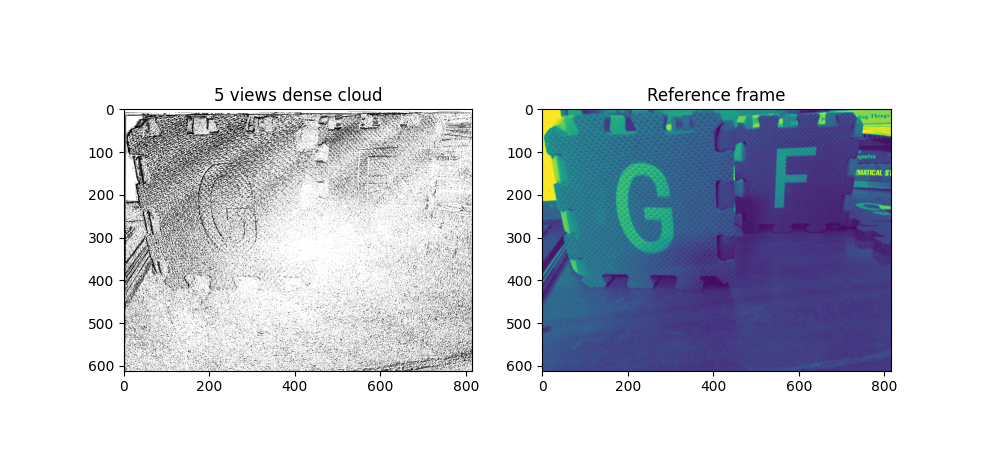

In [10]:
####### computing the dense cloud using 5 views #####
n_views = 5
depth_n_views_5 = plane_sweep(theta_5 , translation_5 , W_5 , cam_intrinsics , images_array[:,:,:n_views])
plt.figure(0)
plt.subplot(1,2,1)
plt.title('5 views dense cloud')
plt.imshow(depth_n_views_5,cmap = "Greys")
plt.subplot(1,2,2)
plt.title('Reference frame')
plt.imshow(images_array[:,:,0])
plt.show()

<IPython.core.display.Javascript object>


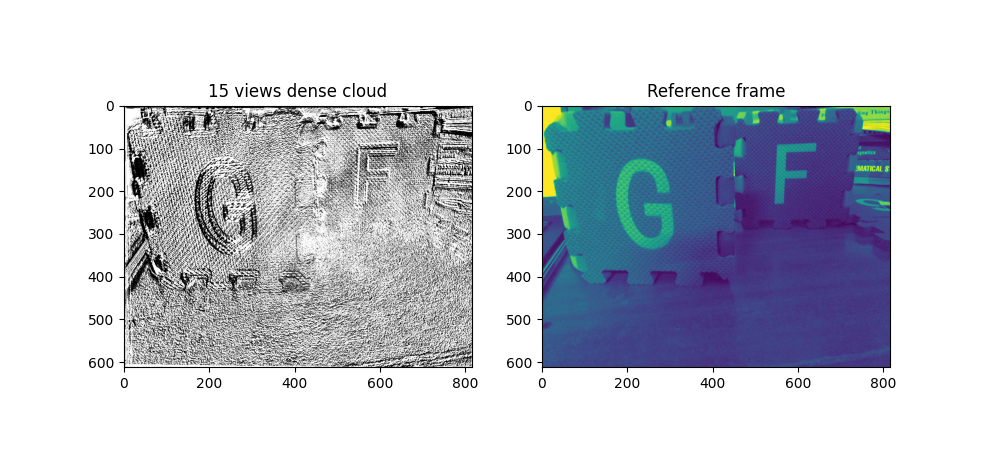

In [11]:
##### computing the depth map for 15 views ####
n_views = 15
depth_n_views_15 = plane_sweep(theta_15 , translation_15 , W_15 , cam_intrinsics , images_array[:,:,:n_views])
plt.figure(1)
plt.subplot(1,2,1)
plt.title('15 views dense cloud')
plt.imshow(depth_n_views_15,cmap = "Greys")
plt.subplot(1,2,2)
plt.title('Reference frame')
plt.imshow(images_array[:,:,0])
plt.show()

<IPython.core.display.Javascript object>


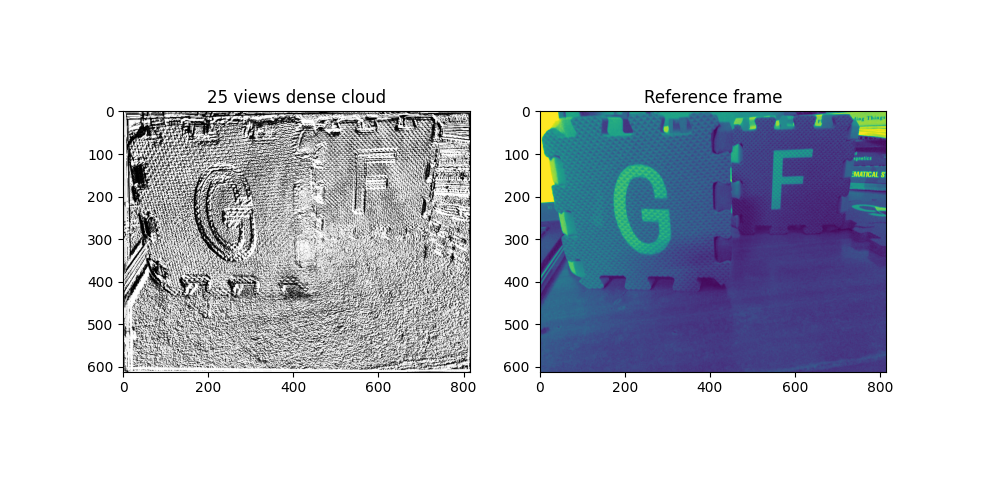

In [13]:
#### computing the depth map for 25 views ######
n_views = 25
depth_n_views_25 = plane_sweep(theta_25 , translation_25 , W_25 , cam_intrinsics , images_array[:,:,:n_views])
plt.figure(2)
plt.subplot(1,2,1)
plt.title('25 views dense cloud')
plt.imshow(depth_n_views_25,cmap = "Greys")
plt.subplot(1,2,2)
plt.title('Reference frame')
plt.imshow(images_array[:,:,0])
plt.show()